# Imports

In [1]:
import sys
sys.path.append('..')
sys.path.append('../src/mlb_models')

import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import pandas as pd
from utils import *

from datetime import date, timedelta, datetime, timezone

import xgboost as xgb
from xgboost import plot_importance
import sklearn
from sklearn.linear_model import LinearRegression
# from exports import EmailHandler 

def rmse(y,y_hat):return np.sqrt(np.mean((y-y_hat)**2))

import dataframe_image as dfi

import pytz
local_tz = pytz.timezone('US/Eastern')
def utc_to_local(utc_dt):
    local_dt = utc_dt.replace(tzinfo=pytz.utc).astimezone(local_tz)
    return local_tz.normalize(local_dt) # .normalize might be unnecessary

def pretty_time(utc_dt):
    local_dt = utc_dt.replace(tzinfo=pytz.utc).astimezone(local_tz)
    return local_tz.normalize(local_dt).strftime('%m/%d %I.%M%p')

best_models = {}

# update schedule and get todays data

In [2]:
from download_game_level_data import ScheduleETL, DataLoaderGame
S = ScheduleETL()
S.update_schedule()

grabbing from 2024-07-28 to 2024-07-31
[datetime.date(2024, 7, 28), datetime.date(2024, 7, 29), datetime.date(2024, 7, 30)]
07-28, 07-29, 07-30, Saving...Saved to ../data/schedule_v1/2024_schedule.parquet!
Schedule in memory
Unrolling and extracting schedule stats.
Extracting prev season batting and hitting stats.
Gathering player lookup table. This may take a moment.


In [3]:
dl = DataLoaderGame()
data = dl.import_merged_data()
future_games = dl.import_upcoming()

# Get data slices
training / validate / test

In [4]:
data_use = data

# get time ranges to subset training. use most recent two weeks to test, and preceeding two weeks for validation
now = datetime.now()
today = date.today()
tomorrow = today + timedelta(days=1)
if now.hour>19: # if after 7PM, lets just predict for tomorrow
    predict_day_cutoff = tomorrow
else:
    predict_day_cutoff = today
two_week_ago = today - timedelta(days=14)
four_week_ago = today - timedelta(days=28)
six_week_ago = today - timedelta(days=28+14)
eight_week_ago = today - timedelta(days=28+28)

t_start = f'{2021}-03-01'
t_validate = four_week_ago.strftime('%Y-%m-%d')
t_test = two_week_ago.strftime('%Y-%m-%d')
# t_validate_param_search = (today - timedelta(days=28+14)).strftime('%Y-%m-%d')


ind_train = (data_use.date_time<=t_validate)&(data_use.date_time>t_start)
ind_validate = (data_use.date_time>t_validate)&(data_use.date_time<t_test)
ind_test = (data_use.date_time>=t_test)&(data_use.date_time<date.today().strftime('%Y-%m-%d'))
# ind_predict = (data_use.date_time>=predict_day_cutoff.strftime('%Y-%m-%d'))

data_imputed = data_use.copy()
data_imputed = data_imputed.fillna(data_imputed.loc[ind_train].mean(numeric_only=True))

future_games_imputed = future_games.copy()
future_games_imputed = future_games_imputed.fillna(data_imputed.mean(numeric_only=True))

print(f'train: {np.sum(ind_train)} validate: {np.sum(ind_validate)} test: {np.sum(ind_test)}')

train: 17273 validate: 530 test: 442


/Users/tim/opt/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:48: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


# Define Models

In [5]:
xg_early_stop = xgb.XGBRegressor(tree_method="hist", early_stopping_rounds=4,enable_categorical=True,max_depth=4,reg_lambda=1.2,reg_alpha=0.9,
                      subsample=0.5)
xg_full = xgb.XGBRegressor(tree_method="hist",enable_categorical=True,max_depth=3,reg_lambda=5.3,reg_alpha=10.9,
                      subsample=0.8)

n_digits = 2
# best_models = {}

def train_xg_early_stop():
    xg_early_stop.fit(x_train, y_train , eval_set=[(x_validate, y_validate)]);
    pred_future = np.round(xg_early_stop.predict(x_predict),n_digits)
    e=np.nan
    if not NO_VALIDATION:
        pred = xg_early_stop.predict(x_test)
        e_test=rmse(y_test,pred)
    return {'name':'xg_early','pred_future':pred_future, 'e_test': e_test}

def train_xg_mdl(mdl,do_flatten=False,name="model"):
    # get validation performance 
    mdl.fit(x_train, y_train)
    if do_flatten:
        f = lambda x: x.flatten()
    else:
        f = lambda x: x
    x_val_stack = pd.concat((x_test,x_validate))
    y_val_stack = pd.concat((y_test,y_validate))
    pred_validate = f(mdl.predict(x_val_stack))
    e_validate  = rmse(y_val_stack.values,pred_validate)
    
    # get future predictions and rmse for test
    x_val_stack_train = pd.concat((x_train,x_validate))
    y_val_stack_train = pd.concat((y_train,y_validate))
    mdl.fit(x_val_stack_train, y_val_stack_train)
    pred_future = np.round(f(mdl.predict(x_predict)),n_digits) # 

    pred = f(mdl.predict(x_test))
    e_test=rmse(y_test.values,pred)
    return {'name':name,'pred_future':pred_future,'pred_validate': pred_validate, 'e_test': e_test,'e_validate':e_validate}


# Feature Selection

test 2.414


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

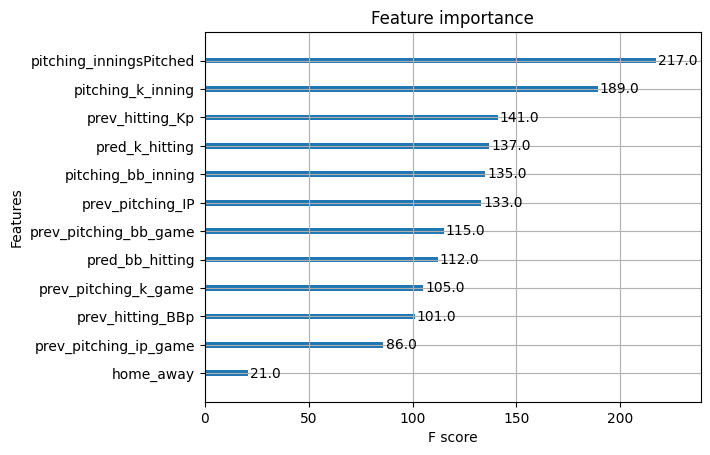

In [6]:
# all
col_x = ['pitcher', 'home_away','pitching_inningsPitched', 'pitching_k_inning', 'pitching_bb_inning',
       'pred_k_hitting', 'pred_bb_hitting', 'prev_pitching_IP',
       'prev_pitching_k_game', 'prev_pitching_bb_game',
       'prev_pitching_ip_game', 'prev_hitting_Kp', 'prev_hitting_BBp',
        'umpire']

# dependable (since umpire data arrives late)
col_x = [ 'home_away','pitching_inningsPitched', 'pitching_k_inning', 'pitching_bb_inning',
       'pred_k_hitting', 'pred_bb_hitting', 'prev_pitching_IP',
       'prev_pitching_k_game', 'prev_pitching_bb_game',
       'prev_pitching_ip_game', 'prev_hitting_Kp', 'prev_hitting_BBp',] # 'pitcher',


col_y = ['k']

data_use = data # data_imputed

x_train, y_train = data_use.loc[ind_train,col_x], data_use.loc[ind_train,col_y]
x_validate, y_validate = data_use.loc[ind_validate,col_x], data_use.loc[ind_validate,col_y]
x_test, y_test = data_use.loc[ind_test,col_x], data_use.loc[ind_test,col_y]
x_predict = future_games.loc[:,col_x]

mdl = xgb.XGBRegressor(tree_method="hist", enable_categorical=True,max_depth=4,reg_lambda=1.2,reg_alpha=0.9,)

mdl.fit(x_train, y_train);

predictions = mdl.predict(x_test)
y_hat_test_xgb = rmse(y_test[col_y[0]],predictions)

print(f'test {y_hat_test_xgb:.3f}')

prediction_future = mdl.predict(x_predict)


prediction_future

plot_importance(mdl)


# Grid Search
- exhaustive search of meta-parameters

In [7]:
from sklearn.model_selection import GridSearchCV

use_imputed = True
if use_imputed:
    data_use_model = data_imputed
    data_use_pred  = future_games_imputed
else:
    data_use_model = data_use
    data_use_pred = future_games
    
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'subsample': [0.5, 0.7, 1]
}

# apply to training data only...
# col_x = [ 'prev_pitching_k_game','prev_pitching_bb_game', 'prev_pitching_ip_game', 
#          'prev_hitting_BBp','prev_hitting_Kp',
#          'pred_k_hitting', 'pred_bb_hitting',
#          'pitching_k_inning', 'pitching_bb_inning',
#         ]
for col_y in ['k','bb']:
    x_train, y_train = data_use_model.loc[ind_train,col_x], data_use_model.loc[ind_train,col_y]

    xgb_model = xgb.XGBRegressor(tree_method="hist",enable_categorical=True,reg_lambda=5.3,reg_alpha=10.9)

    # Create the GridSearchCV object
    grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='neg_mean_squared_error')

    # Fit the GridSearchCV object to the training data
    grid_search.fit(x_train, y_train)
    best_models[f'grid_{col_y}'] = grid_search.best_estimator_
    print("Best set of hyperparameters: ", grid_search.best_params_)
    print("Best score: ", grid_search.best_score_)
    

Best set of hyperparameters:  {'learning_rate': 0.1, 'max_depth': 3, 'subsample': 1}
Best score:  -4.394921094262122
Best set of hyperparameters:  {'learning_rate': 0.1, 'max_depth': 3, 'subsample': 1}
Best score:  -1.269289306662951


# Random Search

In [8]:
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats

param_dist = {
    'max_depth': stats.randint(2, 10),
    'learning_rate': stats.uniform(0.01, 0.2),
    'subsample': stats.uniform(0.5, 0.5),
    'n_estimators':stats.randint(50, 200),
    'reg_lambda':stats.uniform(0.1, 3),
    'reg_alpha': stats.uniform(0.1, 3),
}

for col_y in ['k','bb']:
    x_train, y_train = data_use_model.loc[ind_train,col_x], data_use_model.loc[ind_train,col_y]
    xgb_model = xgb.XGBRegressor(tree_method="hist",enable_categorical=True)
    random_search = RandomizedSearchCV(xgb_model, param_distributions=param_dist, n_iter=30, cv=5, scoring='neg_mean_squared_error')
    
    random_search.fit(x_train, y_train) # this is the actual work-horse
    best_models[f'rand_{col_y}'] = random_search.best_estimator_

    print("Best set of hyperparameters: ", random_search.best_params_)
    print("Best score: ", random_search.best_score_)
    

Best set of hyperparameters:  {'learning_rate': 0.13081987203197154, 'max_depth': 4, 'n_estimators': 88, 'reg_alpha': 0.80660045030544, 'reg_lambda': 1.4724666330363236, 'subsample': 0.966996296455212}
Best score:  -4.398470685341254
Best set of hyperparameters:  {'learning_rate': 0.019983616981717037, 'max_depth': 4, 'n_estimators': 196, 'reg_alpha': 1.749647391607564, 'reg_lambda': 0.4786724633365821, 'subsample': 0.6049734648218462}
Best score:  -1.2672577008129111


# Bayesian Optimization

In [9]:
# from hyperopt import fmin, tpe, hp
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

space = {
    'max_depth': hp.quniform('max_depth', 2, 8, 1),
    'learning_rate': hp.loguniform('learning_rate', -5, -2),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'n_estimators' : hp.quniform('n_estimators',50,200,1),
    'reg_lambda':hp.uniform('reg_lambda',0.1, 3),
    'reg_alpha': hp.uniform('reg_alpha', 0.1, 3),
    
}
# col_y = 'k'
x_train, y_train = data_use_model.loc[ind_train,col_x], data_use_model.loc[ind_train,col_y]
xgb_model = xgb.XGBRegressor(tree_method="hist",enable_categorical=True)

def define_model(space):

    model = xgb.XGBRegressor(tree_method="hist",enable_categorical=True,max_depth = int(space['max_depth']), learning_rate = space['learning_rate'],subsample=space['subsample'],
                              n_estimators =int(space['n_estimators']),reg_lambda=space['reg_lambda'], reg_alpha = space['reg_alpha'])
    return model
def hyperparameter_tuning(space):
    
    model = define_model(space)
    
    x_train, y_train = data_use_model.loc[ind_train,col_x], data_use_model.loc[ind_train,col_y]
    x_test, y_test = data_use.loc[ind_test,col_x], data_use.loc[ind_test,col_y]
    
    model.fit(x_train,y_train)
    pred = model.predict(x_test)
    
    loss_rmse = rmse(y_test.values,pred)
    return {'loss':loss_rmse,'status': STATUS_OK, 'model': model}


for col_y in ['k','bb']:
    trials = Trials()
    best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=60,
            trials=trials)
    best_models[f'bayes_{col_y}'] =  define_model(best)


100%|████████| 60/60 [00:24<00:00,  2.45trial/s, best loss: 1.1835933976180832]


# Summarize and build mixture of models

In [11]:
use_imputed = True
if use_imputed:
    data_use_model = data_imputed
    data_use_pred  = future_games_imputed
else:
    data_use_model = data_use
    data_use_pred = future_games


predict_table = data_use_pred.iloc[:,:8].copy()

NO_VALIDATION = False
tmp = []
for col_y in ['k','bb']:

    x_train, y_train = data_use_model.loc[ind_train,col_x], data_use_model.loc[ind_train,col_y]
    x_validate, y_validate = data_use_model.loc[ind_validate,col_x], data_use_model.loc[ind_validate,col_y]
    x_test, y_test = data_use_model.loc[ind_test,col_x], data_use_model.loc[ind_test,col_y]
#     x_predict = data_use_model.loc[ind_predict,col_x]
    x_predict = data_use_pred.loc[:,col_x]
    
    if NO_VALIDATION:
        x_train, y_train = pd.concat([x_train,x_validate]), pd.concat([y_train,y_validate])
        x_validate, y_validate = x_test, y_test
        
    # currently 3 models
    rmse_xg_early = np.nan
    out_xg_early = train_xg_early_stop()
    
    out_xg = train_xg_mdl(xg_full,name='XG')
#     out_reg = train_xg_mdl(LinearRegression(),True,name='Reg')
    out_grid = train_xg_mdl(best_models[f'grid_{col_y}'],name='XG_grid')
    out_rand = train_xg_mdl(best_models[f'rand_{col_y}'],name='XG_rand')
#     bayes_mdl = xgb.XGBRegressor(tree_method="hist",enable_categorical=True,**best_models[f'bay_{col_y}'])
    out_bayes = train_xg_mdl(best_models[f'bayes_{col_y}'],name='XG_bayes')

   
    _mdl_outs = pd.DataFrame([out_xg,out_grid,out_rand,out_xg_early, out_bayes,out_rand])
    
    
    # get ensamble 
    _mdl_use = _mdl_outs.query('~pred_validate.isnull()')
    pred_ensamble_future = np.mean(np.stack(_mdl_use.pred_validate),0)
    pred_ensamble_validate = np.mean(np.stack(_mdl_use.pred_validate),0)
    e_validate  = rmse(np.r_[y_test,y_validate],pred_ensamble_validate)
    ensamle_mdl = {'name':'ensamble','pred_future':pred_ensamble_future,'pred_validate':pred_ensamble_validate,'e_validate':e_validate}
    _mdl_outs.iloc[-1] = ensamle_mdl
    _mdl_outs['feature'] = col_y
    tmp.append(_mdl_outs)

    
performance = pd.concat(tmp)
perf = performance[['name','e_test','e_validate','feature']]

[0]	validation_0-rmse:2.42854
[1]	validation_0-rmse:2.32511
[2]	validation_0-rmse:2.26750
[3]	validation_0-rmse:2.23013
[4]	validation_0-rmse:2.21071
[5]	validation_0-rmse:2.19267
[6]	validation_0-rmse:2.17159
[7]	validation_0-rmse:2.16294
[8]	validation_0-rmse:2.15300
[9]	validation_0-rmse:2.14791
[10]	validation_0-rmse:2.14024
[11]	validation_0-rmse:2.12592
[12]	validation_0-rmse:2.11851
[13]	validation_0-rmse:2.11344
[14]	validation_0-rmse:2.10884
[15]	validation_0-rmse:2.10618
[16]	validation_0-rmse:2.10699
[17]	validation_0-rmse:2.10420
[18]	validation_0-rmse:2.10183
[19]	validation_0-rmse:2.10122
[20]	validation_0-rmse:2.10577
[21]	validation_0-rmse:2.10607
[22]	validation_0-rmse:2.10773
[23]	validation_0-rmse:2.11234
[0]	validation_0-rmse:1.25363
[1]	validation_0-rmse:1.22390
[2]	validation_0-rmse:1.19896
[3]	validation_0-rmse:1.18507
[4]	validation_0-rmse:1.17449
[5]	validation_0-rmse:1.17191
[6]	validation_0-rmse:1.17170
[7]	validation_0-rmse:1.17183
[8]	validation_0-rmse:1.16

In [12]:
performance

,name,pred_future,pred_validate,e_test,e_validate,feature
0,XG,"[4.78, 5.55, 6.4, 5.54, 3.58, 5.77, 5.77, 7.39...","[4.04186, 5.0432653, 4.6477757, 6.0071154, 4.2...",2.344318,2.207289,k
1,XG_grid,"[5.51, 5.35, 5.97, 5.21, 3.37, 6.26, 5.59, 6.7...","[4.001868, 5.332125, 4.5499907, 5.693697, 4.04...",2.320859,2.210839,k
2,XG_rand,"[5.24, 5.41, 6.11, 5.23, 3.24, 6.18, 6.06, 6.9...","[3.9794626, 5.136052, 4.6085577, 5.8098826, 4....",2.338496,2.207654,k
3,xg_early,"[5.14, 5.46, 5.92, 5.2, 3.65, 6.37, 5.95, 7.28...",NaN,2.391847,NaN,k
4,XG_bayes,"[5.43, 5.19, 5.5, 5.22, 3.89, 6.37, 5.25, 6.64...","[3.9152124, 5.3619146, 4.3828387, 5.3959, 3.88...",2.305824,2.242886,k
5,ensamble,"[3.9835732, 5.2018824, 4.5595446, 5.743295, 4....","[3.9835732, 5.2018824, 4.5595446, 5.743295, 4....",NaN,2.204224,k
0,XG,"[1.46, 2.01, 1.43, 1.91, 0.9, 2.75, 1.8, 1.37,...","[1.5043371, 1.1380588, 1.4272827, 1.1841699, 1...",1.190821,1.177354,bb
1,XG_grid,"[1.48, 2.06, 1.43, 1.78, 0.92, 2.74, 1.86, 1.4...","[1.4364907, 1.3129443, 1.6631968, 1.3543822, 1...",1.176776,1.178851,bb
2,XG_rand,"[1.48, 2.11, 1.39, 1.83, 1.14, 2.6, 1.95, 1.53...","[1.4225917, 1.2984408, 1.6475561, 1.3563412, 1...",1.181002,1.174872,bb
3,xg_early,"[1.48, 2.15, 1.38, 1.91, 1.26, 2.7, 1.96, 1.54...",NaN,1.176059,NaN,bb
